In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import matplotlib
matplotlib.font_manager._rebuild()
plt.rcParams['font.family'] = 'Times New Roman' #全体のフォントを設定
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [71]:
import sys
sys.path.append("/notebooks/nb_IEEE/opmap/")

In [72]:
import opmap
from opmap.rawCam import RawCam
from opmap.vmemMap import VmemMap
from opmap.apdMap import APDMap
from opmap.phaseMapHilbert import PhaseMapHilbert as PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap

In [73]:
def FFT(vmem_1d, N, dt, fc_low=None, fc_high=None):
    fq = np.linspace(0, 1.0/dt, N)
    F = np.fft.fft(vmem_1d)
    if fc_low is not None:
        F[(fq <= fc_low)] = 0
    if fc_high is not None:
        F[(fq >= fc_high)] = 0
    
    F_abs = np.abs(F)
    F_abs_amp = F_abs/N
#     F_abs_amp[0] = F_abs_amp[0]/2
    F_abs_amp[0] = 0
    
    F_ifft = np.fft.ifft(F)
    F_ifft_real = F_ifft.real * 2
    
    return F_ifft_real

In [74]:
def isochronal(pmap, threshold):
    contour = np.zeros_like(pmap.data)

    for i in range(contour.shape[1]):
        for j in range(contour.shape[2]):        
            if pmap.roi[i,j] == 1:
                counter = 0
                for time in range(contour.shape[0]):
                    if time == 0:
                        pass
                    elif ((pmap.data[time-1, i, j] < threshold) * (pmap.data[time, i, j] > threshold)) == 1:
                        counter = 0

                    contour[time, i, j] = counter
                    counter += 1
                
    return contour

## 旋回興奮に対する冷却

In [75]:
import cv2

### 20181121-1/C001H001S0008

In [138]:
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, '20181121-1/C001H001S0008/')
print(data_path)
start = 29000
end = 30000
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181121-1/C001H001S0007/roi.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)
vmem.smooth(size=9)

pmap = PhaseMap(vmem)

# if not os.path.exists(os.path.join(save_parent, 'pmap')):
#     os.makedirs(os.path.join(save_parent, 'pmap'))

# pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
# cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
# subprocess.call(cmd, shell=True)

/mnt/Jalife/ExperimentData/20181121-1/C001H001S0008/


In [139]:
pvmap = PhaseVarianceMap(pmap, size=3)

In [140]:
for i in range(1000):
    dat = copy.deepcopy(pmap.data[i]) - 2
    dat = dat +(dat < -np.pi)*2*np.pi
    
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/jet/pmap/%s.png' % '{0:04d}'.format(i),
               dat*cv2.resize(vmem.roi, (128, 128))*(-1), vmin=-np.pi, vmax=np.pi, cmap='jet')
    plt.close()

In [141]:
for i in range(1000):
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/gray/pvmap/%s.png' % '{0:04d}'.format(i),
               pvmap.data[i]*cv2.resize(vmem.roi, (128, 128)), vmax=1, vmin=0, cmap='gray')
    plt.close()

In [142]:
for time in range(1000):
    pmap = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/jet/pmap/%s.png' % '{0:04d}'.format(time), cv2.IMREAD_UNCHANGED)
    pmap = cv2.cvtColor(pmap, cv2.COLOR_BGR2RGB)
    pvmap = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/gray/pvmap/%s.png' % '{0:04d}'.format(time), cv2.IMREAD_UNCHANGED)
    
    for i in range(128):
        for j in range(128):
            if pvmap[i,j,0] > 255*0.5:
                pvmap[i,j,:] = 255
            else:
                pvmap[i,j,3] = 0
    
    plt.imshow(pmap)
    plt.imshow(pvmap)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0008/29000-30000/jet/pmap_pvmap/%s.png' % '{0:04d}'.format(time), dpi=100)
    plt.close()

### 20181121-1/C001H001S0014

In [143]:
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, '20181121-1/C001H001S0014/')
print(data_path)
start = 29000
end = 30000
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181121-1/C001H001S0014/roi.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)
vmem.smooth(size=9)

pmap = PhaseMap(vmem)

# if not os.path.exists(os.path.join(save_parent, 'pmap')):
#     os.makedirs(os.path.join(save_parent, 'pmap'))

# pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
# cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
# subprocess.call(cmd, shell=True)

/mnt/Jalife/ExperimentData/20181121-1/C001H001S0014/


In [144]:
pvmap = PhaseVarianceMap(pmap, size=3)

In [146]:
for i in range(1000):
    dat = copy.deepcopy(pmap.data[i]) - 2
    dat = dat +(dat < -np.pi)*2*np.pi
    
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0014/29000-30000/jet/pmap/%s.png' % '{0:04d}'.format(i),
               dat*cv2.resize(vmem.roi, (128, 128))*(-1), vmin=-np.pi, vmax=np.pi, cmap='jet')
    plt.close()

In [147]:
for i in range(1000):
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0014/29000-30000/gray/pvmap/%s.png' % '{0:04d}'.format(i),
               pvmap.data[i]*cv2.resize(vmem.roi, (128, 128)), vmax=1, vmin=0, cmap='gray')
    plt.close()

In [148]:
for time in range(1000):
    pmap = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0014/29000-30000/jet/pmap/%s.png' % '{0:04d}'.format(time), cv2.IMREAD_UNCHANGED)
    pmap = cv2.cvtColor(pmap, cv2.COLOR_BGR2RGB)
    pvmap = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0014/29000-30000/gray/pvmap/%s.png' % '{0:04d}'.format(time), cv2.IMREAD_UNCHANGED)
    
    for i in range(128):
        for j in range(128):
            if pvmap[i,j,0] > 255*0.5:
                pvmap[i,j,:] = 255
            else:
                pvmap[i,j,3] = 0
    
    plt.imshow(pmap)
    plt.imshow(pvmap)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181121-1/C001H001S0014/29000-30000/jet/pmap_pvmap/%s.png' % '{0:04d}'.format(time), dpi=100)
    plt.close()

### 20181220-1/C001H001S0012

In [177]:
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, '20181220-1/C001H001S0012/')
print(data_path)
start = 9500
end = 10500
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181220-1/C001H001S0012/roi.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)
vmem.smooth(size=9)

pmap = PhaseMap(vmem)

# if not os.path.exists(os.path.join(save_parent, 'pmap')):
#     os.makedirs(os.path.join(save_parent, 'pmap'))

# pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
# cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
# subprocess.call(cmd, shell=True)

/mnt/Jalife/ExperimentData/20181220-1/C001H001S0012/


In [178]:
pvmap = PhaseVarianceMap(pmap, size=3)

In [151]:
for i in range(1000):
    dat = copy.deepcopy(pmap.data[i]) - 2
    dat = dat +(dat < -np.pi)*2*np.pi
    
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-10500/jet/pmap/%s.png' % '{0:04d}'.format(i),
               dat*cv2.resize(vmem.roi, (128, 128))*(-1), vmin=-np.pi, vmax=np.pi, cmap='jet')
    plt.close()

In [152]:
for i in range(1000):
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-10500/gray/pvmap/%s.png' % '{0:04d}'.format(i),
               pvmap.data[i]*cv2.resize(vmem.roi, (128, 128)), vmax=1, vmin=0, cmap='gray')
    plt.close()

In [153]:
for time in range(1000):
    pmap = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-10500/jet/pmap/%s.png' % '{0:04d}'.format(time), cv2.IMREAD_UNCHANGED)
    pmap = cv2.cvtColor(pmap, cv2.COLOR_BGR2RGB)
    pvmap = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-10500/gray/pvmap/%s.png' % '{0:04d}'.format(time), cv2.IMREAD_UNCHANGED)
    
    for i in range(128):
        for j in range(128):
            if pvmap[i,j,0] > 255*0.5:
                pvmap[i,j,:] = 255
            else:
                pvmap[i,j,3] = 0
    
    plt.imshow(pmap)
    plt.imshow(pvmap)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-10500/jet/pmap_pvmap/%s.png' % '{0:04d}'.format(time), dpi=100)
    plt.close()

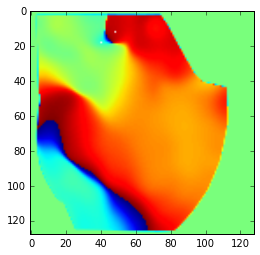

In [194]:
sample = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-10500/jet/pmap/0920.png')
sample[18, 40, :] = 255
sample[12, 48, :] = 255
plt.imshow(sample)

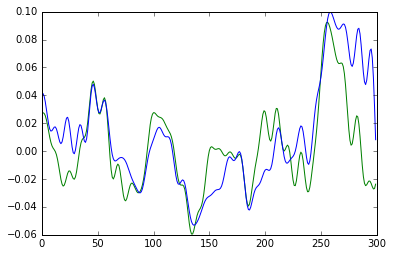

In [195]:
plt.plot(vmem.data[700:, 36, 80], color='green')
plt.plot(vmem.data[700:, 24, 96], color='blue')

### 20181220-1/C001H001S0020

In [196]:
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, '20181220-1/C001H001S0020/')
print(data_path)
start = 7300
end = 8300
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181220-1/C001H001S0020/roi.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)
vmem.smooth(size=9)

pmap = PhaseMap(vmem)

/mnt/Jalife/ExperimentData/20181220-1/C001H001S0020/


In [168]:
pvmap = PhaseVarianceMap(pmap, size=3)

In [156]:
for i in range(1000):
    dat = copy.deepcopy(pmap.data[i]) - 2
    dat = dat +(dat < -np.pi)*2*np.pi
    
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/jet/pmap/%s.png' % '{0:04d}'.format(i),
               dat*cv2.resize(vmem.roi, (128, 128))*(-1), vmin=-np.pi, vmax=np.pi, cmap='jet')
    plt.close()

In [157]:
for i in range(1000):
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/gray/pvmap/%s.png' % '{0:04d}'.format(i),
               pvmap.data[i]*cv2.resize(vmem.roi, (128, 128)), vmax=1, vmin=0, cmap='gray')
    plt.close()

In [158]:
for time in range(1000):
    pmap = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/jet/pmap/%s.png' % '{0:04d}'.format(time), cv2.IMREAD_UNCHANGED)
    pmap = cv2.cvtColor(pmap, cv2.COLOR_BGR2RGB)
    pvmap = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/gray/pvmap/%s.png' % '{0:04d}'.format(time), cv2.IMREAD_UNCHANGED)
    
    for i in range(128):
        for j in range(128):
            if pvmap[i,j,0] > 255*0.5:
                pvmap[i,j,:] = 255
            else:
                pvmap[i,j,3] = 0
    
    plt.imshow(pmap)
    plt.imshow(pvmap)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/jet/pmap_pvmap/%s.png' % '{0:04d}'.format(time), dpi=100)
    plt.close()

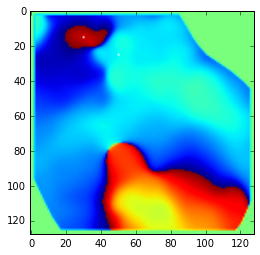

In [216]:
sample = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/jet/pmap/0738.png')
sample[15, 30, :] = 255
sample[25, 50, :] = 255
plt.imshow(sample)

In [241]:
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, '20181220-1/C001H001S0020/')
print(data_path)
start = 7700
end = 8100
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181220-1/C001H001S0020/roi.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)
vmem.smooth(size=9)

/mnt/Jalife/ExperimentData/20181220-1/C001H001S0020/


In [246]:
plt.plot(vmem.data[280:370, 30, 60], color='green', label='x_60_y_30')
plt.plot(vmem.data[280:370, 50, 100], color='blue', label='x_100_y_50')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90], [7980, 7990, 8000, 8010, 8020, 8030, 8040, 8050, 8060, 8070])
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/block_(60,30)vs(100,50).png')
plt.close()
# plt.plot(vmem.data[:, 30, 60], color='green')
# plt.plot(vmem.data[:, 50, 100], color='blue')

## DC2用軌跡

In [102]:
trajectory = np.zeros((128, 128))

for i in range(40):
    pvmap = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/gray/pvmap/%s.png' % '{0:04d}'.format(700+i))
    trajectory += (pvmap[:, :, 0] > 0.5*255)*1

In [104]:
plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/trajectory_for_DC2.png', (trajectory > 0)*1, cmap='gray')

In [106]:
plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/raw_for_DC2.png', raw.data[0], cmap='gray')

In [120]:
raw = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/raw_for_DC2.png', cv2.IMREAD_UNCHANGED)
raw = cv2.resize(raw, (128, 128))
trajectory = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/trajectory_for_DC2.png', cv2.IMREAD_UNCHANGED)

In [121]:
for i in range(128):
    for j in range(128):
        if trajectory[i,j,0] > 128:
            trajectory[i,j,3] = 255
        else:
            trajectory[i,j,3] = 0

In [124]:
plt.imshow(raw)
plt.imshow(trajectory)
plt.xticks([])
plt.yticks([])
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0020/7300-8300/raw_trajectory.png', dpi=100)
plt.close()